In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_97673/430897522.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# exploratory data analysis for housing data
df = pd.read_csv('nyc_housing_price/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [3]:
# acs data
acs = pd.read_csv('ACS.csv')
acs.head()
# at least we got Geo_FIPS for more detailed analysis. Consider filter the required information and concate them into one dataframe for regression.

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,36005000100,"Census Tract 1, Bronx County, New York",ACSSF,ny,140,0,3608,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,"Census Tract 2, Bronx County, New York",ACSSF,ny,140,0,3609,NaN,NaN,NaN,...,833,450,1340,228,384,354,167,89,0,118
2,36005000400,"Census Tract 4, Bronx County, New York",ACSSF,ny,140,0,3610,NaN,NaN,NaN,...,1056,727,2110,402,602,509,426,121,50,0
3,36005001600,"Census Tract 16, Bronx County, New York",ACSSF,ny,140,0,3611,NaN,NaN,NaN,...,1032,738,2153,456,630,338,329,281,79,40
4,36005001901,"Census Tract 19.01, Bronx County, New York",ACSSF,ny,140,0,3612,NaN,NaN,NaN,...,398,208,784,259,282,74,105,39,12,13


In [4]:
# location info
acs_filtered = pd.DataFrame()
acs_filtered['Geo_FIPS'] = acs['Geo_FIPS'].astype(str)
acs_filtered['Geo_QName'] = acs['Geo_QName']
# -----
# race info
"""
Hispanic or Latino by Race (Collapsed Version)
         Universe:  Total Population
         Name:      B04001
         Variables:
            B04001_001:   Total Population:
            B04001_002:      Not Hispanic or Latino:
            B04001_003:         White Alone
            B04001_004:         Black or African American Alone
            B04001_005:         American Indian and Alaska Native Alone
            B04001_006:         Asian Alone
            B04001_007:         Native Hawaiian and Other Pacific Islander Alone
            B04001_008:         Some Other Race Alone
            B04001_009:         Two or More Races
            B04001_010:      Hispanic or Latino
"""
acs_filtered['Total_Pop'] = acs['SE_B04001_001']
acs_filtered['White_Pct'] = acs['SE_B04001_003'] / acs['SE_B04001_001']
acs_filtered['Black_Pct'] = acs['SE_B04001_004'] / acs['SE_B04001_001']
acs_filtered['Asian_Pct'] = acs['SE_B04001_006'] / acs['SE_B04001_001']
acs_filtered['Hispanic_Pct'] = acs['SE_B04001_010'] / acs['SE_B04001_001']
# ----- income
"""
      6. Household Income (In <DollarYear> Inflation Adjusted Dollars) (Collapsed Version)
         Universe:  Households
         Name:      B14001
         Variables:
            B14001_001:   Households:
            B14001_002:      Less than $25,000
            B14001_003:      $25,000 to $49,999
            B14001_004:      $50,000 to $74,999
            B14001_005:      $75,000 to $99,999
            B14001_006:      $100,000 or More


      7. Median Household Income (In <DollarYear> Inflation Adjusted Dollars)
         Universe:  Households
         Name:      A14006
         Variables:
            A14006_001:   Median Household Income (In 2020 Inflation Adjusted Dollars)
"""
acs_filtered['Median_hh_Income'] = acs['SE_A14006_001']
# ----- rent burden
"""
      11. Residents Paying More Than 30% or at least 50% of Income on Rent
          Universe:  Renter-Occupied Housing Units
          Name:      B18002
          Variables:
             B18002_001:   Renter-Occupied Housing Units:
             B18002_002:      30 to 49 Percent
             B18002_003:      50 percent or More
"""
acs_filtered['Rent_30_50pct'] = acs['SE_B18002_002'] / acs['SE_B18002_001']
acs_filtered['Rent_50+pct'] = acs['SE_B18002_003'] / acs['SE_B18002_001']

TODO: Add diversity measurement?

In [5]:
acs_filtered.head()

,Geo_FIPS,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct
0,36005000100,"Census Tract 1, Bronx County, New York",6600,0.123788,0.490000,0.025909,0.350758,NaN,NaN,NaN
1,36005000200,"Census Tract 2, Bronx County, New York",4167,0.018479,0.235181,0.027598,0.706263,68000.0,0.200355,0.329787
2,36005000400,"Census Tract 4, Bronx County, New York",5684,0.065271,0.169775,0.015306,0.729768,93155.0,0.244207,0.165775
3,36005001600,"Census Tract 16, Bronx County, New York",5917,0.038702,0.335643,0.010647,0.563630,34766.0,0.375396,0.164731
4,36005001901,"Census Tract 19.01, Bronx County, New York",1910,0.135602,0.319372,0.000000,0.538743,61711.0,0.185567,0.293814


In [6]:
# tree density
# notice that this is at block group level -> FIPS = FIPS[:-1]
tree = pd.read_csv('tree_density.csv')
tree.head()

,OBJECTID,NYC_Block_group_tree_temp_pollution_STATEFP,NYC_Block_group_tree_temp_pollution_COUNTYFP,NYC_Block_group_tree_temp_pollution_TRACTCE,NYC_Block_group_tree_temp_pollution_BLKGRPCE,NYC_Block_group_tree_temp_pollution_GEOID,NYC_Block_group_tree_temp_pollution_NAMELSAD,NYC_Block_group_tree_temp_pollution_MTFCC,NYC_Block_group_tree_temp_pollution_FUNCSTAT,NYC_Block_group_tree_temp_pollution_ALAND,...,ZonalSt_NYC_Blo4_MEAN,ZonalSt_NYC_Blo5_MEAN,ZonalSt_NYC_Blo6_MEAN,ZonalSt_NYC_Blo7_MEAN,mean_greenview,Point_Count,Shape_Length,Shape_Area,mean_greenview_1,Point_Count_1
0,1,36,5,17500,2,360050175002,Block Group 2,G5030,S,23694,...,38.549822,30.220745,12.052770,19.298550,11.757559,7,0.006462,0.000003,15.503791,5.0
1,2,36,5,14100,1,360050141001,Block Group 1,G5030,S,55934,...,40.587548,30.559553,11.456192,18.933006,14.332636,13,0.014530,0.000006,13.517106,14.0
2,3,36,5,14500,1,360050145001,Block Group 1,G5030,S,47026,...,39.404331,30.279003,11.623620,18.288589,16.691333,5,0.010131,0.000005,18.115964,4.0
3,4,36,5,7500,2,360050075002,Block Group 2,G5030,S,109058,...,40.222442,30.366108,11.090182,18.372196,20.966755,20,0.014512,0.000012,20.787891,20.0
4,5,36,5,41800,1,360050418001,Block Group 1,G5030,S,140793,...,38.649227,29.801424,9.759182,16.992909,16.698220,22,0.023164,0.000015,15.575710,22.0


In [7]:
tree.columns

Index(['OBJECTID', 'NYC_Block_group_tree_temp_pollution_STATEFP',
       'NYC_Block_group_tree_temp_pollution_COUNTYFP',
       'NYC_Block_group_tree_temp_pollution_TRACTCE',
       'NYC_Block_group_tree_temp_pollution_BLKGRPCE',
       'NYC_Block_group_tree_temp_pollution_GEOID',
       'NYC_Block_group_tree_temp_pollution_NAMELSAD',
       'NYC_Block_group_tree_temp_pollution_MTFCC',
       'NYC_Block_group_tree_temp_pollution_FUNCSTAT',
       'NYC_Block_group_tree_temp_pollution_ALAND',
       'NYC_Block_group_tree_temp_pollution_AWATER',
       'NYC_Block_group_tree_temp_pollution_INTPTLAT',
       'NYC_Block_group_tree_temp_pollution_INTPTLON',
       'NYC_Block_group_tree_temp_pollution_Area',
       'NYC_Block_group_tree_temp_pollution_Number_of_trees',
       'NYC_Block_group_tree_temp_pollution_Tree_density',
       'NYC_Block_group_tree_temp_pollution_Mean_PM2', 'ZonalSt_NYC_Blo4_MEAN',
       'ZonalSt_NYC_Blo5_MEAN', 'ZonalSt_NYC_Blo6_MEAN',
       'ZonalSt_NYC_Blo7_MEAN', 

In [8]:
tree_filtered = pd.DataFrame()
tree_filtered['Geo_FIPS'] = tree['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
tree_filtered['tree_density'] = tree['NYC_Block_group_tree_temp_pollution_Tree_density']
tree_filtered['tree_num'] = tree['NYC_Block_group_tree_temp_pollution_Number_of_trees']
tree_filtered.head()

,Geo_FIPS,tree_density,tree_num
0,36005017500,0.000149,38
1,36005014100,0.000048,29
2,36005014500,0.000103,52
3,36005007500,0.000194,228
4,36005041800,0.000060,91


In [9]:
# gvi - interesting, all data are contained in this same data frame
gvi = pd.read_csv('GVI.csv')
gvi.head()

,OBJECTID,NYC_Block_group_tree_temp_pollution_STATEFP,NYC_Block_group_tree_temp_pollution_COUNTYFP,NYC_Block_group_tree_temp_pollution_TRACTCE,NYC_Block_group_tree_temp_pollution_BLKGRPCE,NYC_Block_group_tree_temp_pollution_GEOID,NYC_Block_group_tree_temp_pollution_NAMELSAD,NYC_Block_group_tree_temp_pollution_MTFCC,NYC_Block_group_tree_temp_pollution_FUNCSTAT,NYC_Block_group_tree_temp_pollution_ALAND,...,ZonalSt_NYC_Blo4_MEAN,ZonalSt_NYC_Blo5_MEAN,ZonalSt_NYC_Blo6_MEAN,ZonalSt_NYC_Blo7_MEAN,mean_greenview,Point_Count,Shape_Length,Shape_Area,mean_greenview_1,Point_Count_1
0,1,36,5,17500,2,360050175002,Block Group 2,G5030,S,23694,...,38.549822,30.220745,12.052770,19.298550,11.757559,7,0.006462,0.000003,15.503791,5.0
1,2,36,5,14100,1,360050141001,Block Group 1,G5030,S,55934,...,40.587548,30.559553,11.456192,18.933006,14.332636,13,0.014530,0.000006,13.517106,14.0
2,3,36,5,14500,1,360050145001,Block Group 1,G5030,S,47026,...,39.404331,30.279003,11.623620,18.288589,16.691333,5,0.010131,0.000005,18.115964,4.0
3,4,36,5,7500,2,360050075002,Block Group 2,G5030,S,109058,...,40.222442,30.366108,11.090182,18.372196,20.966755,20,0.014512,0.000012,20.787891,20.0
4,5,36,5,41800,1,360050418001,Block Group 1,G5030,S,140793,...,38.649227,29.801424,9.759182,16.992909,16.698220,22,0.023164,0.000015,15.575710,22.0


In [10]:
gvi_filtered = pd.DataFrame()
gvi_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
gvi_filtered['GVI'] = gvi['mean_greenview_1']
gvi_filtered.head()

,Geo_FIPS,GVI
0,36005017500,15.503791
1,36005014100,13.517106
2,36005014500,18.115964
3,36005007500,20.787891
4,36005041800,15.575710


In [11]:
# air quality
air = pd.read_csv('pollution/Air_Quality.csv')
air.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,216498,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2013,06/01/2013,34.64,NaN
1,216499,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2014,06/01/2014,33.22,NaN
2,219969,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2013,06/01/2013,31.25,NaN
3,219970,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2014,06/01/2014,31.15,NaN
4,164876,383,Sulfur Dioxide (SO2),Mean,ppb,CD,211,Morris Park and Bronxdale (CD11),Winter 2008-09,12/01/2008,5.89,NaN


In [12]:
air['Name'].unique()

array(['Ozone (O3)', 'Sulfur Dioxide (SO2)', 'PM2.5-Attributable Deaths',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Air Toxics Concentrations- Average Benzene Concentrations',
       'Air Toxics Concentrations- Average Formaldehyde Concentrations',
       'PM2.5-Attributable Asthma Emergency Department Visits',
       'PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older)',
       'PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older)',
       'Traffic Density- Annual Vehicle Miles Traveled',
       'O3-Attributable Cardiac and Respiratory Deaths',
       'O3-Attributable Asthma Emergency Department Visits',
       'O3-Attributable Asthma Hospitalizations',
       'Traffic Density- Annual Vehicle Miles Traveled for Cars',
       'Traffic Density- Annual Vehicle Miles Traveled for Trucks',
       'Nitrogen Dioxide (NO2)', 'Fine Partic

In [13]:
pollution_filtered = pd.DataFrame()
pollution_filtered['Geo_FIPS'] = gvi['NYC_Block_group_tree_temp_pollution_GEOID'].astype(str).apply(lambda x: x[:-1])
pollution_filtered['PM2.5'] = gvi['NYC_Block_group_tree_temp_pollution_Mean_PM2']
pollution_filtered.head()

,Geo_FIPS,PM2.5
0,36005017500,6.074496
1,36005014100,6.073939
2,36005014500,6.198496
3,36005007500,6.040218
4,36005041800,5.950134


In [14]:
# need to filter out the data for regression
# also see intercorrelation between variables

In [15]:
# census tract geometry
ct = gpd.read_file('ct.json')

In [16]:
ct.head()

,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape__Area,Shape__Length,geometry
0,1,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,1.844391e+06,11022.881754,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ..."
1,2,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,9.723121e+05,4754.495247,"POLYGON ((-73.98450 40.70952, -73.98655 40.709..."
2,3,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,2.582705e+06,6976.286456,"POLYGON ((-73.99022 40.71441, -73.98934 40.714..."
3,4,14.01,1,Manhattan,001401,1001401,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,1.006117e+06,5075.332000,"POLYGON ((-73.98837 40.71645, -73.98754 40.716..."
4,5,14.02,1,Manhattan,001402,1001402,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,1.226206e+06,4459.156019,"POLYGON ((-73.98507 40.71909, -73.98423 40.718..."


In [17]:
# merge data
aggregate = gpd.GeoDataFrame()
aggregate['geometry'] = ct['geometry']
aggregate['Geo_FIPS'] = ct['GEOID'].astype(str)
aggregate['BoroName'] = ct['BoroName']
aggregate['NTAName'] = ct['NTAName']
# -----
# ACS data
aggregate = aggregate.merge(acs_filtered, on='Geo_FIPS')
# -----
# tree density
aggregate = aggregate.merge(tree_filtered, on='Geo_FIPS')
# -----
# gvi
aggregate = aggregate.merge(gvi_filtered, on='Geo_FIPS')
# -----
# air quality
aggregate = aggregate.merge(pollution_filtered, on='Geo_FIPS')


In [18]:
aggregate[aggregate['Geo_FIPS'] == '36005017500']

,geometry,Geo_FIPS,BoroName,NTAName,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct,tree_density,tree_num,GVI,PM2.5
16606,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000149,38,15.503791,6.074496
16607,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000149,38,15.503791,6.083557
16608,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000149,38,15.503791,NaN
16609,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000149,38,15.503791,NaN
16610,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000149,38,15.503791,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16817,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000164,43,18.212969,6.083557
16818,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000164,43,18.212969,NaN
16819,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000164,43,18.212969,NaN
16820,"POLYGON ((-73.91139 40.83100, -73.91177 40.830...",36005017500,Bronx,Concourse-Concourse Village,"Census Tract 175, Bronx County, New York",6584,0.025668,0.460055,0.00243,0.48952,24399.0,0.196291,0.321204,0.000164,43,18.212969,NaN


In [19]:
aggregate.head()

,geometry,Geo_FIPS,BoroName,NTAName,Geo_QName,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct,tree_density,tree_num,GVI,PM2.5
0,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",36061000100,Manhattan,The Battery-Governors Island-Ellis Island-Libe...,"Census Tract 1, New York County, New York",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,NaN,5.743412
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,6.532890
2,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,1.638854,NaN
3,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,6.532890
4,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",36061000201,Manhattan,Chinatown-Two Bridges,"Census Tract 2.01, New York County, New York",2761,0.061572,0.046722,0.273089,0.604853,30435.0,0.372685,0.168981,0.000041,29,17.656432,NaN


In [20]:
# save the data
aggregate.to_file('aggregate.geojson', driver='GeoJSON')

In [21]:
# variable cov matrix
aggregate.corr()

/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_97673/850332073.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  aggregate.corr()


,Total_Pop,White_Pct,Black_Pct,Asian_Pct,Hispanic_Pct,Median_hh_Income,Rent_30_50pct,Rent_50+pct,tree_density,tree_num,GVI,PM2.5
Total_Pop,1.000000,0.110052,-0.183881,-0.040196,0.083669,0.115698,-0.030585,-0.140784,0.142006,-0.219274,-0.018000,0.192443
White_Pct,0.110052,1.000000,-0.604246,0.012971,-0.646197,0.728901,-0.297021,-0.345062,0.265423,0.117298,0.130271,0.215087
Black_Pct,-0.183881,-0.604246,1.000000,-0.366567,-0.003043,-0.357772,0.135336,0.164400,-0.240661,-0.073582,-0.088895,-0.216230
Asian_Pct,-0.040196,0.012971,-0.366567,1.000000,-0.293199,0.058044,-0.004533,-0.019133,-0.050874,0.167503,0.075128,0.060130
Hispanic_Pct,0.083669,-0.646197,-0.003043,-0.293199,1.000000,-0.595056,0.237729,0.282936,-0.059420,-0.179642,-0.114997,-0.077881
Median_hh_Income,0.115698,0.728901,-0.357772,0.058044,-0.595056,1.000000,-0.327075,-0.487148,0.304557,0.123973,0.114847,0.297596
Rent_30_50pct,-0.030585,-0.297021,0.135336,-0.004533,0.237729,-0.327075,1.000000,-0.085846,-0.115181,-0.067502,-0.041659,-0.054035
Rent_50+pct,-0.140784,-0.345062,0.164400,-0.019133,0.282936,-0.487148,-0.085846,1.000000,-0.106654,-0.041466,-0.071587,-0.212255
tree_density,0.142006,0.265423,-0.240661,-0.050874,-0.059420,0.304557,-0.115181,-0.106654,1.000000,0.121412,0.097660,0.150625
tree_num,-0.219274,0.117298,-0.073582,0.167503,-0.179642,0.123973,-0.067502,-0.041466,0.121412,1.000000,0.318470,-0.347974


/var/folders/tl/kq7bhnbd4yxd5mt28m9t8g100000gn/T/ipykernel_97673/1342306783.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aggregate.corr(), annot=True)


<AxesSubplot: >

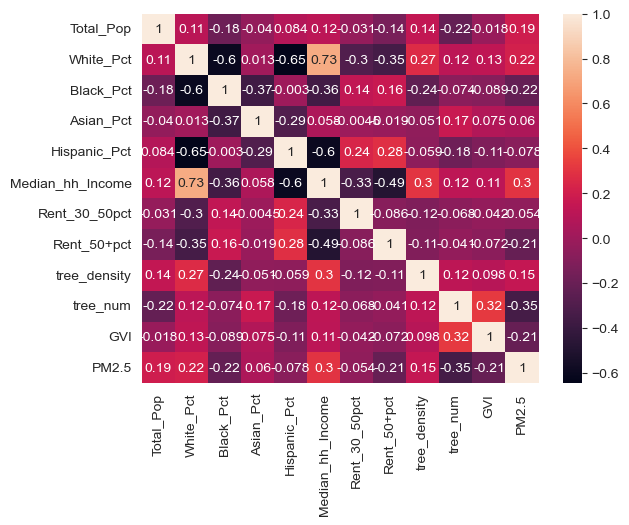

In [22]:
# cov matrix plot
sns.heatmap(aggregate.corr(), annot=True)

<AxesSubplot: xlabel='GVI', ylabel='tree_density'>

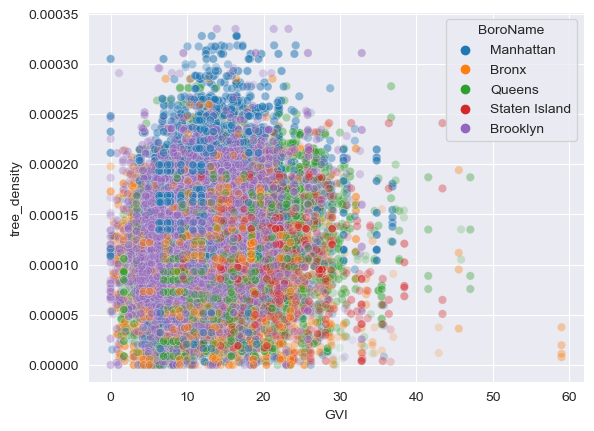

In [23]:
# gvi vs. tree density
sns.scatterplot(data=aggregate, x='GVI', y='tree_density', hue='BoroName', alpha=0.1)


<AxesSubplot: >

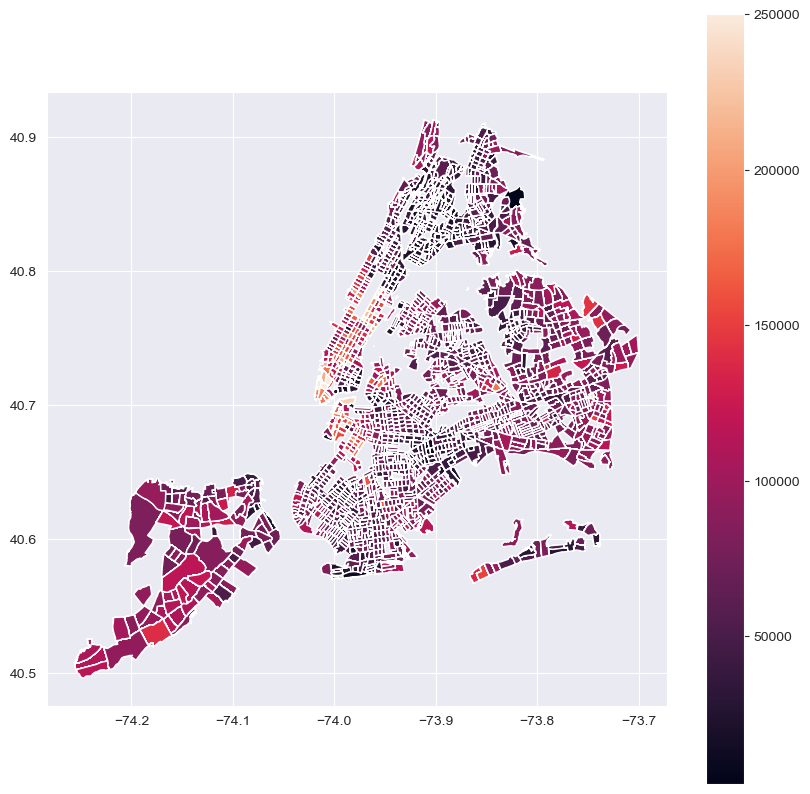

In [24]:
# plot the data
fig, ax = plt.subplots(figsize=(10, 10))
aggregate.plot(column='Median_hh_Income', ax=ax, legend=True)

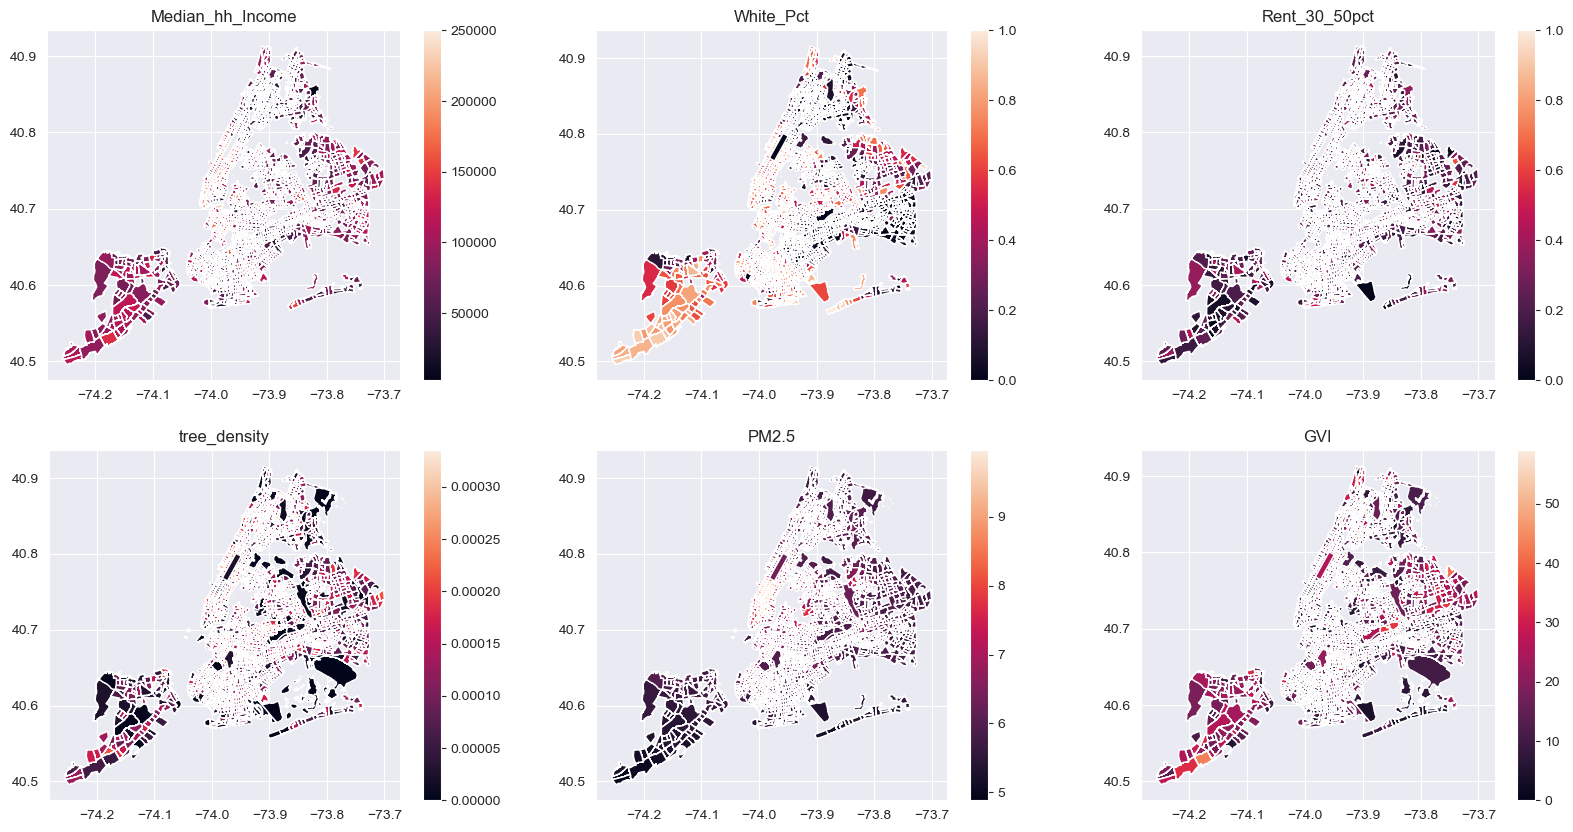

In [39]:
variables_interest = ['Median_hh_Income','White_Pct', 'Rent_30_50pct', 'tree_density','PM2.5', 'GVI']
# visualize these variables of interest
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i, var in enumerate(variables_interest):
    ax = plt.subplot(2, 3, i+1)
    aggregate.plot(column=var, ax=ax, legend=True)
    ax.set_title(var)



In [25]:
aggregate.columns()

TypeError: 'Index' object is not callable

In [26]:


# simple OLS, income vs. other variables
import statsmodels.api as sm
variables = ['White_Pct', 'Rent_30_50pct', 'tree_density','PM2.5', 'GVI']

# clean data with missing values
aggregate_ols = aggregate.dropna(subset=variables + ['Median_hh_Income'])

x = aggregate_ols[variables]
y = aggregate_ols['Median_hh_Income']

# build ols model
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       Median_hh_Income   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                          7.447e+04
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:37:02   Log-Likelihood:                     -4.8886e+05
No. Observations:               42002   AIC:                                  9.777e+05
Df Residuals:                   41997   BIC:                                  9.778e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [31]:
# what are the most important variables?
# standardize the independent variables to compare the coefficients
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

model_standardized = sm.OLS(y, x_scaled)
results_standardized = model_standardized.fit()
print(results_standardized.summary())

                                 OLS Regression Results                                
Dep. Variable:       Median_hh_Income   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              844.1
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:42:51   Log-Likelihood:                     -5.3492e+05
No. Observations:               42002   AIC:                                  1.070e+06
Df Residuals:                   41997   BIC:                                  1.070e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<AxesSubplot: >

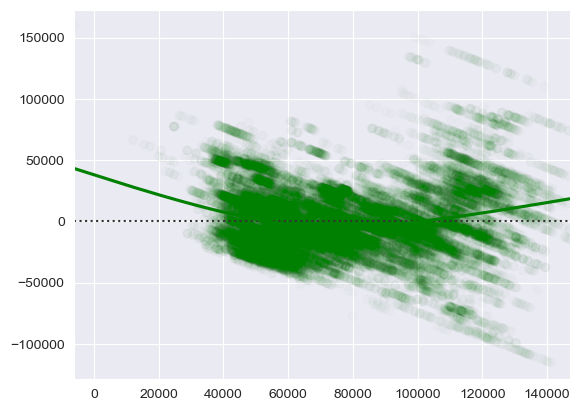

In [38]:
# get the residual plot
sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True, color="g", scatter_kws={'alpha':0.01})

In [32]:
x_scaled = pd.DataFrame(x_scaled, columns=variables)
x_scaled.head()

,White_Pct,Rent_30_50pct,tree_density,PM2.5,GVI
0,-0.980005,1.832278,-1.447570,0.402126,-1.979354
1,-0.980005,1.832278,-1.447570,0.402126,0.527641
2,-0.980005,1.832278,0.308685,0.402126,-1.979354
3,-0.980005,1.832278,0.308685,0.402126,0.527641
4,-1.009883,1.771973,-1.309653,0.717868,-0.316673


In [33]:
x.head()

,White_Pct,Rent_30_50pct,tree_density,PM2.5,GVI
1,0.061572,0.372685,0.000041,6.532890,1.638854
3,0.061572,0.372685,0.000041,6.532890,17.656432
5,0.061572,0.372685,0.000138,6.532890,1.638854
7,0.061572,0.372685,0.000138,6.532890,17.656432
9,0.052879,0.367733,0.000049,6.745528,12.261979


In [ ]:
# include controls besides envrionmetnal